# Load data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from datetime import datetime

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

import os
import sys
from pathlib import Path

PROJ_ROOT = Path(os.getcwd()).parent.parent
sys.path.append(str(PROJ_ROOT))  # add project root file to the python paths
data_path = PROJ_ROOT / "data"

from vol_predict.backtest.benchmark_backtester import BenchmarkBacktester
from vol_predict.models.baselines.benchmarks import Naive, EWMA, ARIMAX, GARCH, HARX
from vol_predict.models.baselines.benchmarks import ENET, RF, XGBM

sns.set(style="whitegrid")
# sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("savefig", dpi=90)
plt.rc("font", family="sans-serif")
plt.rc("font", size=14)

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(


In [3]:
NUM_LAGS = 10
LAGS = [1, 6, 24]  # for HARX moving averages

full_data = (
    (
        pl.read_csv(data_path / "btc" / "data_df_with_volume.csv")
        .with_columns(pl.col("datetime").str.to_datetime("%Y-%m-%d %H:%M:%S"))
        .sort("datetime")
    )
    .to_pandas()
    .set_index("datetime")
)

for i in range(1, NUM_LAGS + 1):
    full_data[f"vol_lag{i}"] = full_data["vol"].shift(i)

# add log volatilitiess
full_data["log_vol"] = np.log(full_data["vol"])
for i in range(1, NUM_LAGS + 1):
    full_data[f"log_vol_lag{i}"] = full_data["log_vol"].shift(i)

full_data.loc[:, ["log_volume"]] = np.log(full_data.loc[:, "volume"] + 0.0000001)

raw_features_names = [
    "spread",
    # "ask_depth", # = const
    "bid_depth",
    # "depth_diff", # = bid_depth - ask_depth(const)
    "ask_volume",
    "bid_volume",  # eliminated in the features engineering stage
    "volume_diff",  # = bid_volume - ask_volume (redundant in linear models)
    "weighted_spread",  #  eliminated in the features engineering stage, no correlation with volatility
    "ask_slope",
    "bid_slope",  # eliminated in the features engineering stage, very correlated with ask_slope
]


for col in raw_features_names:
    columns_to_use = full_data.columns[full_data.columns.str.startswith(col)]
    # sort columns by the time delta, e.g. "bid_volume_t-1", "bid_volume_t-2", ..., "bid_volume_t-60"
    columns_to_use = sorted(columns_to_use, key=lambda x: int(x.split("_t-")[-1]))

    full_data[f"mean_{col}"] = full_data.loc[
        :, full_data.columns.str.startswith(col)
    ].mean(axis=1)
    full_data[f"iq_range_{col}"] = np.log(
        0.0001
        + (
            full_data.loc[:, columns_to_use[:]].quantile(0.75, axis=1)
            - full_data.loc[:, columns_to_use[:]].quantile(0.25, axis=1)
        )
        / full_data.loc[:, columns_to_use[:]].median(axis=1)
    )
    full_data[f"trend_{col}"] = full_data.loc[:, columns_to_use[:60]].mean(
        axis=1
    ) - full_data.loc[:, columns_to_use[60:]].mean(axis=1)

# moving average of log_vol_lag1. These are the main features of HAR model
for lag in LAGS:
    full_data.loc[:, f"log_vol_lag1_smooth{lag}"] = (
        full_data.loc[:, "log_vol_lag1"].rolling(window=lag).mean()
    )

selected_ob_features = [
    "mean_spread",
    "mean_bid_depth",
    "mean_ask_volume",
    "iq_range_bid_depth",
    "iq_range_ask_volume",
    "iq_range_ask_slope",
]

large_ob_features = [
    "mean_spread",
    "mean_bid_depth",
    "mean_ask_volume",
    "mean_bid_volume",
    "mean_weighted_spread",
    "mean_ask_slope",
    "mean_bid_slope",
    "trend_spread",
    "trend_bid_depth",
    "trend_ask_volume",
    "trend_bid_volume",
    "trend_weighted_spread",
    "trend_ask_slope",
    "trend_bid_slope",
    "iq_range_spread",
    "iq_range_bid_depth",
    "iq_range_ask_volume",
    "iq_range_bid_volume",
    "iq_range_weighted_spread",
    "iq_range_ask_slope",
    "iq_range_bid_slope",
]


dataset = full_data.loc[
    :,
    # RESPONSE
    ["vol", "ret", "log_vol"]
    +
    # ['log_vol']   +
    # FEATURES
    [f"vol_lag{i}" for i in range(1, NUM_LAGS + 1)]
    + [f"log_vol_lag{i}" for i in range(1, NUM_LAGS + 1)]
    + [f"log_vol_lag1_smooth{lag}" for lag in LAGS]
    + ["log_volume"]
    + large_ob_features,
].dropna()


# LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
# init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
dataset.columns

Index(['vol', 'ret', 'log_vol', 'vol_lag1', 'vol_lag2', 'vol_lag3', 'vol_lag4',
       'vol_lag5', 'vol_lag6', 'vol_lag7', 'vol_lag8', 'vol_lag9', 'vol_lag10',
       'log_vol_lag1', 'log_vol_lag2', 'log_vol_lag3', 'log_vol_lag4',
       'log_vol_lag5', 'log_vol_lag6', 'log_vol_lag7', 'log_vol_lag8',
       'log_vol_lag9', 'log_vol_lag10', 'log_vol_lag1_smooth1',
       'log_vol_lag1_smooth6', 'log_vol_lag1_smooth24', 'log_volume',
       'mean_spread', 'mean_bid_depth', 'mean_ask_volume', 'mean_bid_volume',
       'mean_weighted_spread', 'mean_ask_slope', 'mean_bid_slope',
       'trend_spread', 'trend_bid_depth', 'trend_ask_volume',
       'trend_bid_volume', 'trend_weighted_spread', 'trend_ask_slope',
       'trend_bid_slope', 'iq_range_spread', 'iq_range_bid_depth',
       'iq_range_ask_volume', 'iq_range_bid_volume',
       'iq_range_weighted_spread', 'iq_range_ask_slope', 'iq_range_bid_slope'],
      dtype='object')

In [5]:
output_template = pd.read_csv(data_path / "btc" / "output_template.csv", index_col=0)
output_template.index = pd.to_datetime(output_template.index)

In [6]:
IS_EXPANDING = False
suffix = "expanding" if IS_EXPANDING else "rolling"
LOOK_BACK = pd.Timedelta(days=30)

In [7]:
LAST_TRAINING_DATE = datetime.strptime("2018-06-30 23:59:59", "%Y-%m-%d %H:%M:%S")
init_training_vola = dataset.loc[:LAST_TRAINING_DATE]

In [8]:
backtester = BenchmarkBacktester(
    dataset=dataset,
    output_template=output_template,
    last_train_date=LAST_TRAINING_DATE,
    is_training_expanded=IS_EXPANDING,
    lookback=LOOK_BACK,
)

# Backtesting Univariate models

## Naive

  0%|          | 0/1958 [00:00<?, ?it/s]

100%|██████████| 1958/1958 [00:02<00:00, 686.63it/s]


Backtest finished successfully.
---------------------------------------------------
Model: Naive
RMSE: 0.0002826
MAE:  0.0000921
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


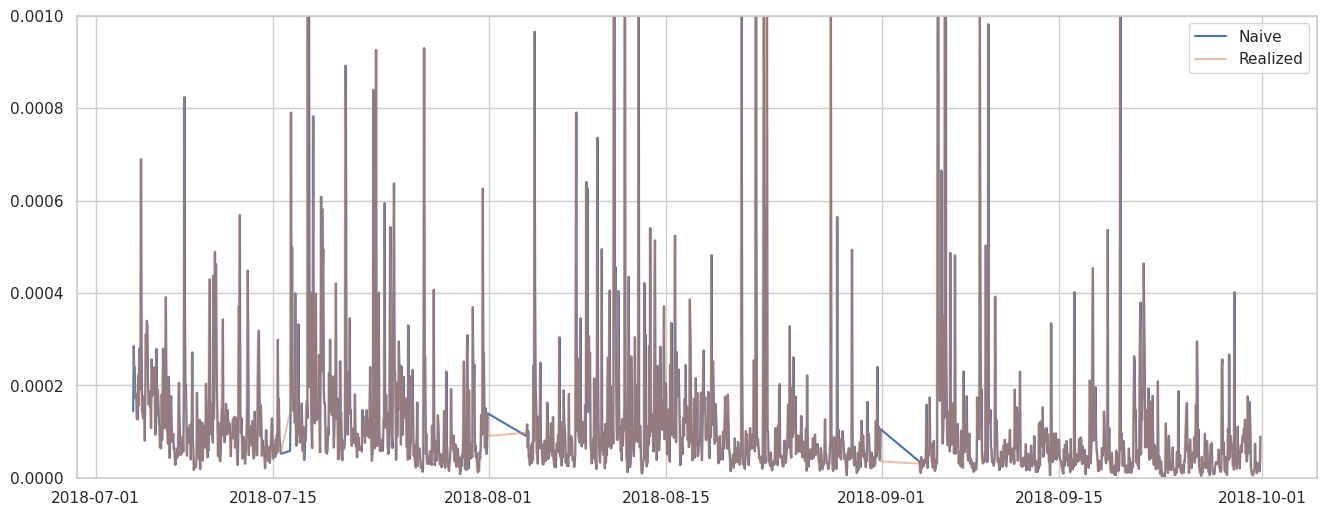

In [9]:
backtest_results_naive = backtester.backtest(Naive, use_ob_feats=False, use_log_y=False)

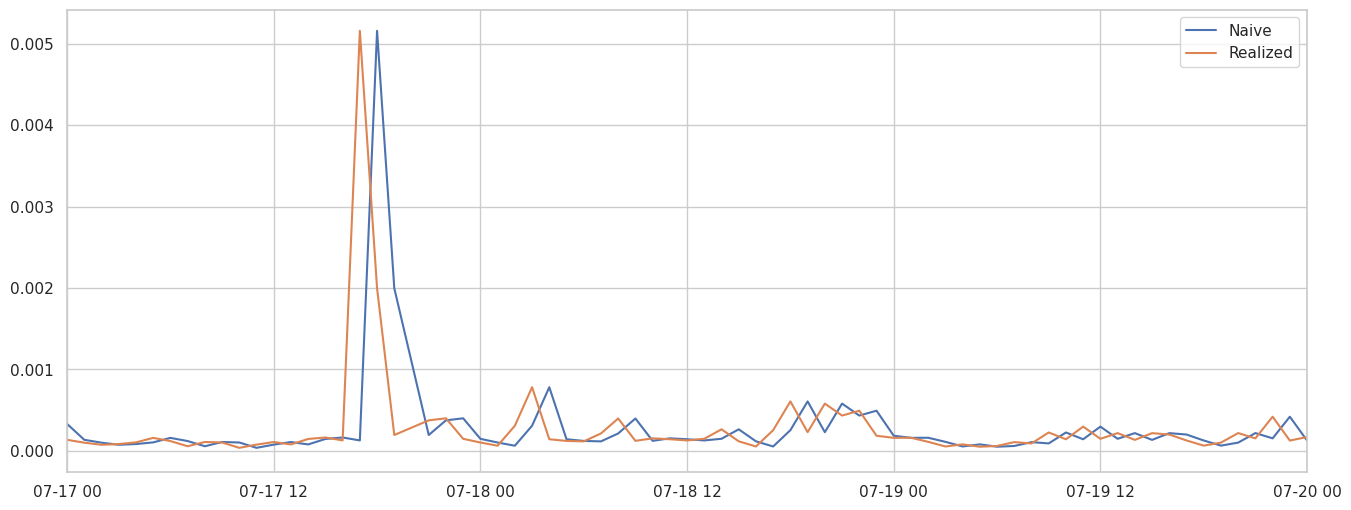

In [10]:
plt.plot(backtest_results_naive.forecasts, label="Naive")
plt.plot(backtest_results_naive.true_vola, label="Realized")
plt.xlim(
    datetime.strptime("2018-07-17 00:00:00", "%Y-%m-%d %H:%M:%S"),
    datetime.strptime("2018-07-20 00:00:00", "%Y-%m-%d %H:%M:%S"),
)
plt.legend()

In [11]:
backtest_results_naive.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"naive_{suffix}.csv",
    index=True,
)

## EWMA

  0%|          | 0/1958 [00:00<?, ?it/s]

100%|██████████| 1958/1958 [00:03<00:00, 605.65it/s]


Backtest finished successfully.
---------------------------------------------------
Model: EWMA
RMSE: 0.0002551
MAE:  0.0000938
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


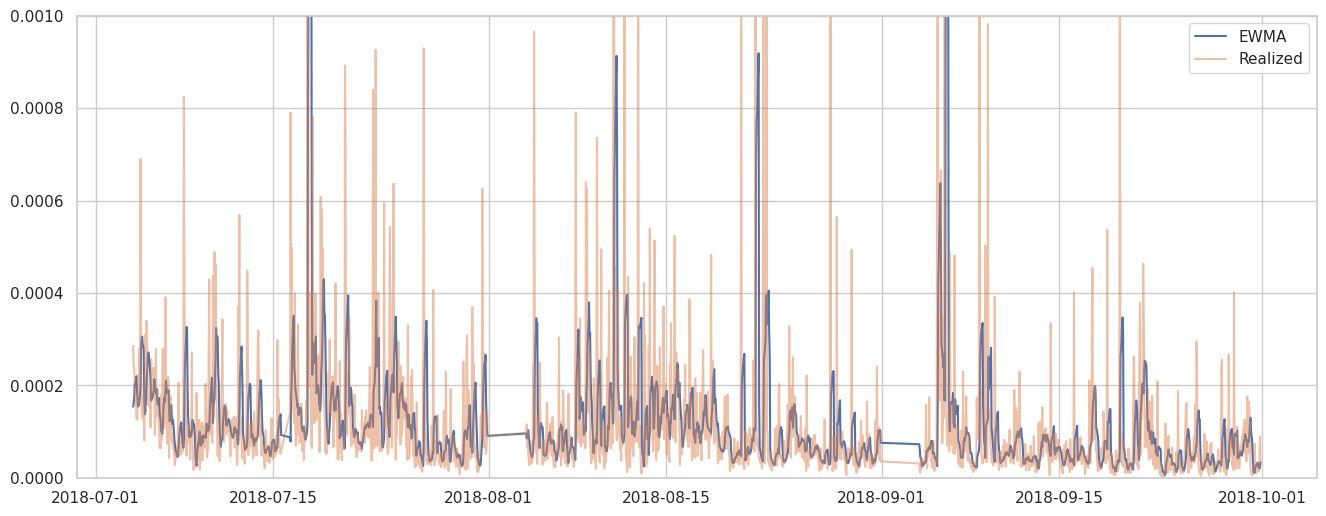

In [12]:
backtest_results_ewma = backtester.backtest(
    EWMA,
    hyperparams={"look_back": 6, "half_life": 12},
    use_ob_feats=False,
    use_log_y=False,
)

In [14]:
backtest_results_ewma.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"ewma_{suffix}.csv",
    index=True,
)

<Axes: xlabel='datetime'>

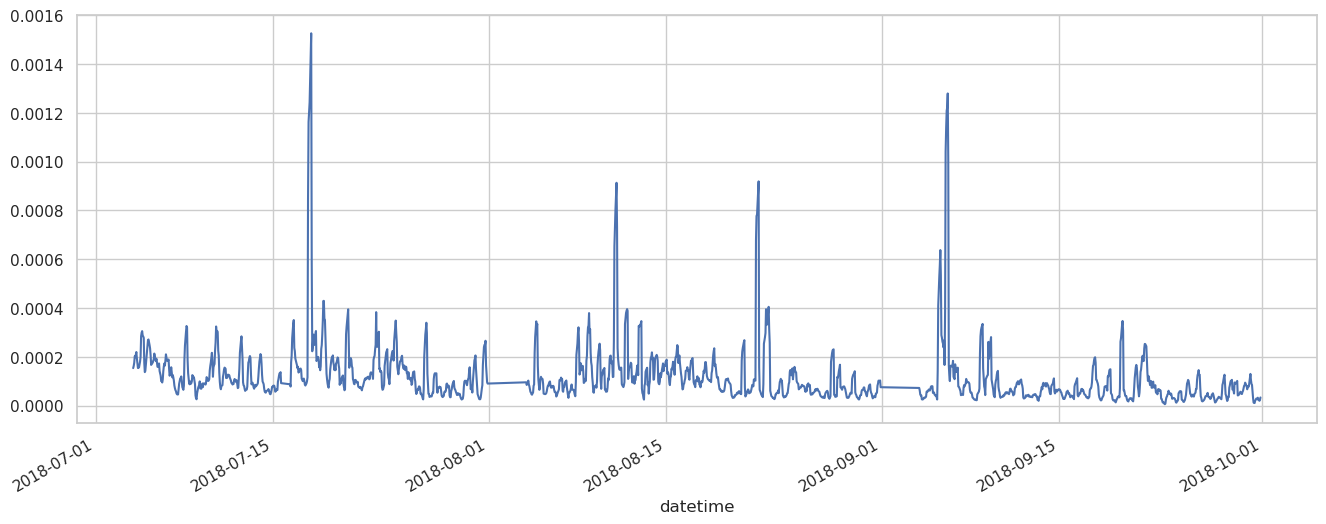

In [15]:
backtest_results_ewma.forecasts.plot(label="EWMA")

## ARIMA

  1%|          | 12/1958 [00:00<00:34, 56.70it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  597
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -474.843
Date:                Sun, 29 Jun 2025   AIC                            957.686
Time:                        21:13:27   BIC                            975.254
Sample:                             0   HQIC                           964.527
                                - 597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6036      0.090    -95.786      0.000      -8.780      -8.428
ar.L1          0.8353      0.033     25.651      0.000       0.771       0.899
ma.L1         -0.3434      0.055     -6.293      0.0

  7%|▋         | 129/1958 [00:01<00:23, 76.22it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  644
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -515.989
Date:                Sun, 29 Jun 2025   AIC                           1039.977
Time:                        21:13:28   BIC                           1057.848
Sample:                             0   HQIC                          1046.912
                                - 644                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.6382      0.090    -96.099      0.000      -8.814      -8.462
ar.L1          0.8251      0.032     25.547      0.000       0.762       0.888
ma.L1         -0.2852      0.054     -5.329      0.0

 12%|█▏        | 244/1958 [00:03<00:31, 53.84it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  643
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -523.353
Date:                Sun, 29 Jun 2025   AIC                           1054.705
Time:                        21:13:30   BIC                           1072.570
Sample:                             0   HQIC                          1061.638
                                - 643                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.7915      0.075   -116.613      0.000      -8.939      -8.644
ar.L1          0.7794      0.035     22.321      0.000       0.711       0.848
ma.L1         -0.2380      0.056     -4.260      0.0

 18%|█▊        | 355/1958 [00:04<00:20, 76.78it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  626
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -554.053
Date:                Sun, 29 Jun 2025   AIC                           1116.106
Time:                        21:13:31   BIC                           1133.863
Sample:                             0   HQIC                          1123.005
                                - 626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.8534      0.077   -115.547      0.000      -9.004      -8.703
ar.L1          0.7398      0.040     18.407      0.000       0.661       0.819
ma.L1         -0.1935      0.060     -3.242      0.0

 24%|██▍       | 469/1958 [00:05<00:17, 85.05it/s] 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  625
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -570.251
Date:                Sun, 29 Jun 2025   AIC                           1148.501
Time:                        21:13:32   BIC                           1166.252
Sample:                             0   HQIC                          1155.399
                                - 625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.9288      0.072   -123.949      0.000      -9.070      -8.788
ar.L1          0.6948      0.047     14.867      0.000       0.603       0.786
ma.L1         -0.1627      0.063     -2.569      0.0

 30%|██▉       | 587/1958 [00:07<00:20, 65.29it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  624
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -607.567
Date:                Sun, 29 Jun 2025   AIC                           1223.135
Time:                        21:13:34   BIC                           1240.879
Sample:                             0   HQIC                          1230.030
                                - 624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.0775      0.075   -120.682      0.000      -9.225      -8.930
ar.L1          0.6899      0.045     15.223      0.000       0.601       0.779
ma.L1         -0.1557      0.059     -2.629      0.0

 34%|███▍      | 661/1958 [00:08<00:17, 75.96it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  625
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -631.665
Date:                Sun, 29 Jun 2025   AIC                           1271.330
Time:                        21:13:35   BIC                           1289.081
Sample:                             0   HQIC                          1278.227
                                - 625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.2276      0.068   -134.827      0.000      -9.362      -9.093
ar.L1          0.6190      0.052     11.937      0.000       0.517       0.721
ma.L1         -0.0875      0.065     -1.353      0.1

 39%|███▉      | 763/1958 [00:09<00:15, 77.75it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  626
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -651.389
Date:                Sun, 29 Jun 2025   AIC                           1310.777
Time:                        21:13:36   BIC                           1328.535
Sample:                             0   HQIC                          1317.677
                                - 626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.2984      0.071   -131.134      0.000      -9.437      -9.159
ar.L1          0.6243      0.054     11.553      0.000       0.518       0.730
ma.L1         -0.1218      0.067     -1.816      0.0

 45%|████▍     | 876/1958 [00:10<00:13, 79.08it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  629
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -706.347
Date:                Sun, 29 Jun 2025   AIC                           1420.695
Time:                        21:13:37   BIC                           1438.471
Sample:                             0   HQIC                          1427.600
                                - 629                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.2828      0.076   -122.826      0.000      -9.431      -9.135
ar.L1          0.6035      0.060     10.009      0.000       0.485       0.722
ma.L1         -0.1263      0.071     -1.784      0.0

 51%|█████     | 995/1958 [00:12<00:11, 87.14it/s] 

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  645
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -722.881
Date:                Sun, 29 Jun 2025   AIC                           1453.762
Time:                        21:13:39   BIC                           1471.639
Sample:                             0   HQIC                          1460.698
                                - 645                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.3046      0.066   -140.825      0.000      -9.434      -9.175
ar.L1          0.5643      0.068      8.288      0.000       0.431       0.698
ma.L1         -0.1179      0.076     -1.545      0.1

 57%|█████▋    | 1117/1958 [00:13<00:11, 73.21it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  646
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -750.720
Date:                Sun, 29 Jun 2025   AIC                           1509.441
Time:                        21:13:40   BIC                           1527.324
Sample:                             0   HQIC                          1516.379
                                - 646                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.3725      0.069   -135.061      0.000      -9.508      -9.236
ar.L1          0.5344      0.069      7.725      0.000       0.399       0.670
ma.L1         -0.0727      0.078     -0.934      0.3

 63%|██████▎   | 1237/1958 [00:14<00:10, 68.39it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  646
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -733.830
Date:                Sun, 29 Jun 2025   AIC                           1475.661
Time:                        21:13:42   BIC                           1493.544
Sample:                             0   HQIC                          1482.599
                                - 646                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.4420      0.070   -134.284      0.000      -9.580      -9.304
ar.L1          0.5765      0.068      8.471      0.000       0.443       0.710
ma.L1         -0.1334      0.078     -1.712      0.0

 68%|██████▊   | 1334/1958 [00:16<00:08, 75.71it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  646
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -735.272
Date:                Sun, 29 Jun 2025   AIC                           1478.545
Time:                        21:13:43   BIC                           1496.428
Sample:                             0   HQIC                          1485.483
                                - 646                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.4879      0.072   -131.865      0.000      -9.629      -9.347
ar.L1          0.5943      0.069      8.626      0.000       0.459       0.729
ma.L1         -0.1682      0.079     -2.122      0.0

 72%|███████▏  | 1408/1958 [00:17<00:08, 68.26it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  646
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -760.758
Date:                Sun, 29 Jun 2025   AIC                           1529.517
Time:                        21:13:44   BIC                           1547.400
Sample:                             0   HQIC                          1536.455
                                - 646                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.4523      0.083   -114.180      0.000      -9.615      -9.290
ar.L1          0.6352      0.063     10.021      0.000       0.511       0.759
ma.L1         -0.1864      0.074     -2.519      0.0

 78%|███████▊  | 1522/1958 [00:18<00:05, 84.74it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  640
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -725.359
Date:                Sun, 29 Jun 2025   AIC                           1458.717
Time:                        21:13:45   BIC                           1476.563
Sample:                             0   HQIC                          1465.644
                                - 640                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.5748      0.084   -113.930      0.000      -9.740      -9.410
ar.L1          0.6785      0.060     11.289      0.000       0.561       0.796
ma.L1         -0.2533      0.073     -3.463      0.0

 84%|████████▎ | 1635/1958 [00:19<00:04, 74.32it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  640
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -713.211
Date:                Sun, 29 Jun 2025   AIC                           1434.423
Time:                        21:13:46   BIC                           1452.269
Sample:                             0   HQIC                          1441.350
                                - 640                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.7332      0.079   -122.619      0.000      -9.889      -9.578
ar.L1          0.6572      0.061     10.702      0.000       0.537       0.778
ma.L1         -0.2432      0.075     -3.238      0.0

 90%|█████████ | 1764/1958 [00:21<00:02, 80.17it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  640
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -714.355
Date:                Sun, 29 Jun 2025   AIC                           1436.711
Time:                        21:13:48   BIC                           1454.557
Sample:                             0   HQIC                          1443.638
                                - 640                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.8094      0.085   -115.202      0.000      -9.976      -9.643
ar.L1          0.7163      0.052     13.712      0.000       0.614       0.819
ma.L1         -0.2969      0.067     -4.463      0.0

 96%|█████████▌| 1874/1958 [00:22<00:01, 73.37it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  641
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -758.264
Date:                Sun, 29 Jun 2025   AIC                           1524.529
Time:                        21:13:49   BIC                           1542.381
Sample:                             0   HQIC                          1531.457
                                - 641                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.9014      0.094   -105.327      0.000     -10.086      -9.717
ar.L1          0.7560      0.045     16.668      0.000       0.667       0.845
ma.L1         -0.3301      0.064     -5.177      0.0

100%|██████████| 1958/1958 [00:23<00:00, 83.22it/s]


Backtest finished successfully.
---------------------------------------------------
Model: ARIMA
RMSE: 0.0002298
MAE:  0.0000875
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


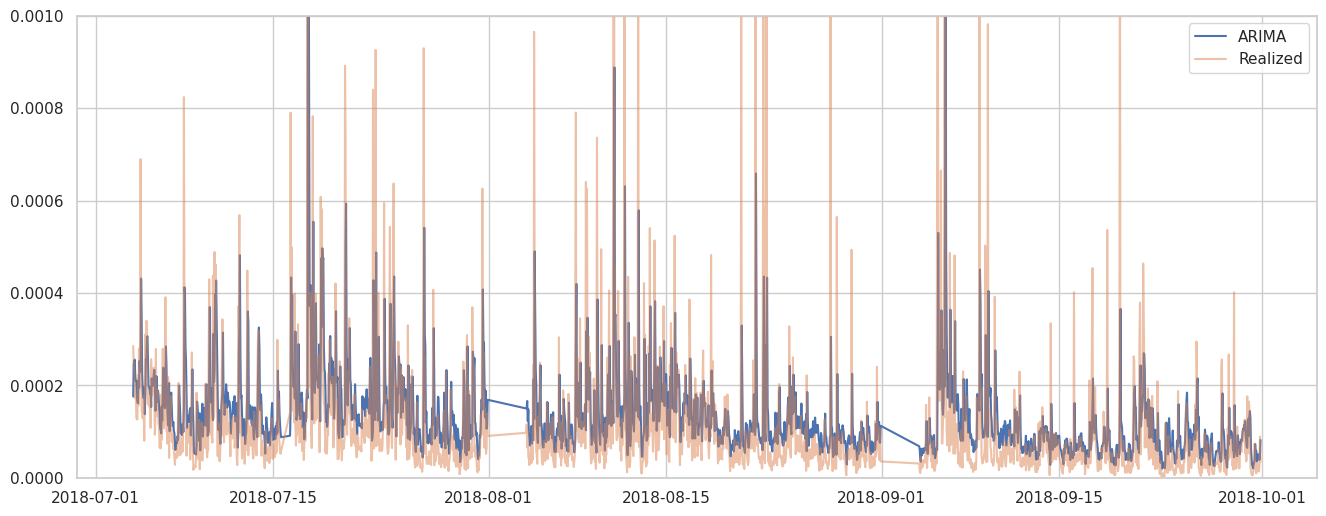

In [16]:
backtest_results_arima = backtester.backtest(
    ARIMAX, hyperparams={"p": 1, "d": 0, "q": 1}, use_ob_feats=False, use_log_y=True
)

In [17]:
backtest_results_arima.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"arima_{suffix}.csv",
    index=True,
)

## GARCH

### GARCH(1, 1) with Normal dist.

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.769e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  3%|▎         | 52/1958 [00:00<00:07, 268.62it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2106.46
Distribution:                  Normal   AIC:                          -4204.92
Method:            Maximum Likelihood   BIC:                          -4187.35
                                        No. Observations:                  597
Date:                Sun, Jun 29 2025   Df Residuals:                      596
Time:                        21:17:55   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -1.0755e-04  2.859e-04     -0.376      0.

  6%|▌         | 108/1958 [00:00<00:07, 240.40it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.632e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  8%|▊         | 158/1958 [00:00<00:08, 212.37it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2277.99
Distribution:                  Normal   AIC:                          -4547.97
Method:            Maximum Likelihood   BIC:                          -4530.10
                                        No. Observations:                  644
Date:                Sun, Jun 29 2025   Df Residuals:                      643
Time:                        21:17:56   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -5.3787e-05  2.508e-04     -0.214      0.

 11%|█▏        | 224/1958 [00:01<00:08, 201.65it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.506e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 13%|█▎        | 263/1958 [00:01<00:10, 157.49it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2363.61
Distribution:                  Normal   AIC:                          -4719.21
Method:            Maximum Likelihood   BIC:                          -4701.35
                                        No. Observations:                  643
Date:                Sun, Jun 29 2025   Df Residuals:                      642
Time:                        21:17:56   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -9.1215e-05  1.805e-04     -0.505      0.

 16%|█▌        | 316/1958 [00:01<00:07, 207.81it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.911e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 19%|█▉        | 369/1958 [00:01<00:06, 230.98it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2274.31
Distribution:                  Normal   AIC:                          -4540.61
Method:            Maximum Likelihood   BIC:                          -4522.86
                                        No. Observations:                  626
Date:                Sun, Jun 29 2025   Df Residuals:                      625
Time:                        21:17:57   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.3480e-05  1.784e-04      0.132      0.895 

 23%|██▎       | 443/1958 [00:02<00:07, 210.97it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.627e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 25%|██▌       | 497/1958 [00:02<00:06, 237.06it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2287.79
Distribution:                  Normal   AIC:                          -4567.59
Method:            Maximum Likelihood   BIC:                          -4549.84
                                        No. Observations:                  625
Date:                Sun, Jun 29 2025   Df Residuals:                      624
Time:                        21:17:57   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.9407e-04  1.964e-04      0.988      0.323 

 28%|██▊       | 554/1958 [00:02<00:05, 257.75it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.983e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 31%|███       | 610/1958 [00:02<00:05, 265.16it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2295.91
Distribution:                  Normal   AIC:                          -4583.82
Method:            Maximum Likelihood   BIC:                          -4566.08
                                        No. Observations:                  624
Date:                Sun, Jun 29 2025   Df Residuals:                      623
Time:                        21:17:58   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.0202e-04  2.037e-04      1.483      0.138 

 33%|███▎      | 637/1958 [00:02<00:05, 254.50it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.51e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 35%|███▌      | 694/1958 [00:03<00:05, 245.09it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2346.20
Distribution:                  Normal   AIC:                          -4684.40
Method:            Maximum Likelihood   BIC:                          -4666.65
                                        No. Observations:                  625
Date:                Sun, Jun 29 2025   Df Residuals:                      624
Time:                        21:17:58   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         1.5584e-04  1.967e-05      7.924  2.294e-15 [1.

 37%|███▋      | 721/1958 [00:03<00:04, 251.39it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.882e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 40%|███▉      | 775/1958 [00:03<00:05, 233.75it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2315.89
Distribution:                  Normal   AIC:                          -4623.78
Method:            Maximum Likelihood   BIC:                          -4606.02
                                        No. Observations:                  626
Date:                Sun, Jun 29 2025   Df Residuals:                      625
Time:                        21:17:59   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         8.4744e-05  4.307e-07    196.747      0.000 [8.

 43%|████▎     | 835/1958 [00:03<00:04, 243.24it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.27e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 46%|████▌     | 891/1958 [00:03<00:04, 233.25it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2210.88
Distribution:                  Normal   AIC:                          -4413.75
Method:            Maximum Likelihood   BIC:                          -4395.97
                                        No. Observations:                  629
Date:                Sun, Jun 29 2025   Df Residuals:                      628
Time:                        21:17:59   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         1.5988e-04  3.006e-04      0.532      0.595 

 50%|█████     | 980/1958 [00:04<00:03, 271.67it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.236e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 53%|█████▎    | 1035/1958 [00:04<00:03, 261.64it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                1037.00
Distribution:                  Normal   AIC:                          -2066.00
Method:            Maximum Likelihood   BIC:                          -2048.13
                                        No. Observations:                  645
Date:                Sun, Jun 29 2025   Df Residuals:                      644
Time:                        21:18:00   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu             0.0283  1.057e-03     26.733 1.966e-157 [2.

 55%|█████▌    | 1086/1958 [00:04<00:04, 217.35it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.858e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 58%|█████▊    | 1136/1958 [00:05<00:03, 224.13it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2231.44
Distribution:                  Normal   AIC:                          -4454.87
Method:            Maximum Likelihood   BIC:                          -4436.99
                                        No. Observations:                  646
Date:                Sun, Jun 29 2025   Df Residuals:                      645
Time:                        21:18:00   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
mu         -2.0000e-04  3.035e-04     -0.659      0.

 62%|██████▏   | 1222/1958 [00:05<00:02, 261.94it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.244e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 64%|██████▍   | 1249/1958 [00:05<00:02, 253.61it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2274.27
Distribution:                  Normal   AIC:                          -4540.54
Method:            Maximum Likelihood   BIC:                          -4522.65
                                        No. Observations:                  646
Date:                Sun, Jun 29 2025   Df Residuals:                      645
Time:                        21:18:01   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
-------------------------------------------------------------------------------
mu         -1.8043e-04  2.931e-05     -6.157  7.4

 66%|██████▋   | 1299/1958 [00:05<00:03, 198.81it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.938e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 69%|██████▉   | 1348/1958 [00:05<00:02, 215.35it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2294.58
Distribution:                  Normal   AIC:                          -4581.15
Method:            Maximum Likelihood   BIC:                          -4563.27
                                        No. Observations:                  646
Date:                Sun, Jun 29 2025   Df Residuals:                      645
Time:                        21:18:01   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu         3.2619e-05  2.576e-06     12.662  9.619e-37 [2.

 70%|███████   | 1375/1958 [00:06<00:02, 229.00it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.348e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 73%|███████▎  | 1427/1958 [00:06<00:02, 228.22it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2269.83
Distribution:                  Normal   AIC:                          -4531.66
Method:            Maximum Likelihood   BIC:                          -4513.78
                                        No. Observations:                  646
Date:                Sun, Jun 29 2025   Df Residuals:                      645
Time:                        21:18:01   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         3.7783e-05  2.180e-05      1.733  8.304e-02 

 75%|███████▌  | 1475/1958 [00:06<00:02, 220.52it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.198e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 78%|███████▊  | 1532/1958 [00:06<00:01, 238.91it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2324.02
Distribution:                  Normal   AIC:                          -4640.03
Method:            Maximum Likelihood   BIC:                          -4622.18
                                        No. Observations:                  640
Date:                Sun, Jun 29 2025   Df Residuals:                      639
Time:                        21:18:02   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         7.4917e-05  2.543e-04      0.295      0.768 

 82%|████████▏ | 1607/1958 [00:07<00:01, 217.39it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.293e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 85%|████████▍ | 1659/1958 [00:07<00:01, 221.67it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2404.54
Distribution:                  Normal   AIC:                          -4801.07
Method:            Maximum Likelihood   BIC:                          -4783.22
                                        No. Observations:                  640
Date:                Sun, Jun 29 2025   Df Residuals:                      639
Time:                        21:18:02   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         8.0349e-05  2.241e-04      0.358      0.720 

 89%|████████▉ | 1744/1958 [00:07<00:00, 262.83it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.908e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 92%|█████████▏| 1798/1958 [00:07<00:00, 258.65it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2475.41
Distribution:                  Normal   AIC:                          -4942.82
Method:            Maximum Likelihood   BIC:                          -4924.97
                                        No. Observations:                  640
Date:                Sun, Jun 29 2025   Df Residuals:                      639
Time:                        21:18:03   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         2.0384e-04  2.137e-04      0.954      0.340 

 94%|█████████▍| 1850/1958 [00:08<00:00, 230.28it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.915e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 97%|█████████▋| 1900/1958 [00:08<00:00, 236.96it/s]

                     Constant Mean - GARCH Model Results                      
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                2482.22
Distribution:                  Normal   AIC:                          -4956.44
Method:            Maximum Likelihood   BIC:                          -4938.58
                                        No. Observations:                  641
Date:                Sun, Jun 29 2025   Df Residuals:                      640
Time:                        21:18:03   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.7218e-05  2.180e-04      0.217      0.829 

100%|██████████| 1958/1958 [00:08<00:00, 226.90it/s]


Backtest finished successfully.
---------------------------------------------------
Model: Garch_normal
RMSE: 0.0002486
MAE:  0.0000947
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


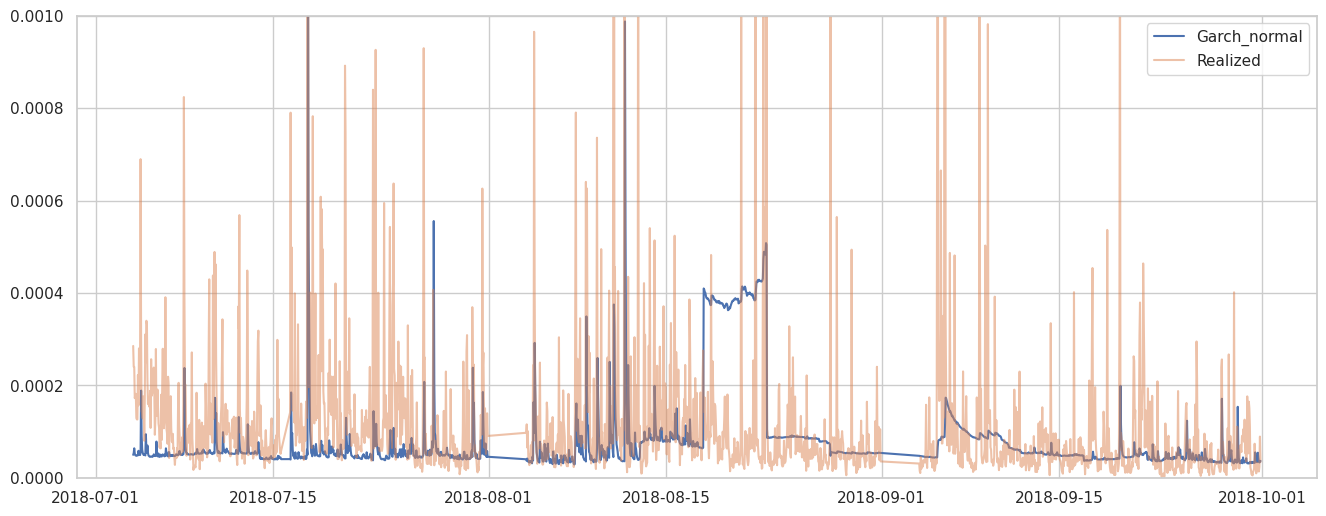

In [20]:
backtest_results_garch = backtester.backtest(
    GARCH,
    hyperparams={"p": 1, "o": 0, "q": 1, "dist": "normal"},
    use_ob_feats=False,
    use_log_y=True,
)

In [48]:
backtest_results_garch.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"garch_{suffix}.csv",
    index=True,
)

### GARCH(1, 1) with Student's t dist. 

  0%|          | 0/1958 [00:00<?, ?it/s]

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.769e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  1%|          | 23/1958 [00:00<00:15, 123.48it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2892.06
Distribution:      Standardized Student's t   AIC:                           5794.13
Method:                  Maximum Likelihood   BIC:                           5816.09
                                              No. Observations:                  597
Date:                      Sun, Jun 29 2025   Df Residuals:                      596
Time:                              21:21:22   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            10

  4%|▍         | 86/1958 [00:00<00:10, 186.89it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.632e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
  8%|▊         | 150/1958 [00:00<00:08, 201.86it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1004.34
Distribution:      Standardized Student's t   AIC:                          -1998.69
Method:                  Maximum Likelihood   BIC:                          -1976.35
                                              No. Observations:                  644
Date:                      Sun, Jun 29 2025   Df Residuals:                      643
Time:                              21:21:23   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

 12%|█▏        | 231/1958 [00:01<00:07, 237.91it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.506e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 14%|█▍        | 283/1958 [00:01<00:06, 243.04it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -243.716
Distribution:      Standardized Student's t   AIC:                           497.433
Method:                  Maximum Likelihood   BIC:                           519.763
                                              No. Observations:                  643
Date:                      Sun, Jun 29 2025   Df Residuals:                      642
Time:                              21:21:24   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

 17%|█▋        | 339/1958 [00:01<00:06, 259.25it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.911e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 20%|██        | 393/1958 [00:01<00:06, 249.64it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -99831.0
Distribution:      Standardized Student's t   AIC:                           199672.
Method:                  Maximum Likelihood   BIC:                           199694.
                                              No. Observations:                  626
Date:                      Sun, Jun 29 2025   Df Residuals:                      625
Time:                              21:21:24   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

 23%|██▎       | 444/1958 [00:02<00:06, 227.71it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.627e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 25%|██▌       | 499/1958 [00:02<00:06, 235.25it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1912.75
Distribution:      Standardized Student's t   AIC:                          -3815.49
Method:                  Maximum Likelihood   BIC:                          -3793.30
                                              No. Observations:                  625
Date:                      Sun, Jun 29 2025   Df Residuals:                      624
Time:                              21:21:25   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

 28%|██▊       | 558/1958 [00:02<00:05, 260.10it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.983e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 31%|███▏      | 614/1958 [00:02<00:05, 251.47it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -6298.87
Distribution:      Standardized Student's t   AIC:                           12607.7
Method:                  Maximum Likelihood   BIC:                           12629.9
                                              No. Observations:                  624
Date:                      Sun, Jun 29 2025   Df Residuals:                      623
Time:                              21:21:25   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           -20

 33%|███▎      | 642/1958 [00:02<00:05, 256.74it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.51e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 35%|███▌      | 692/1958 [00:03<00:07, 179.94it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2084.60
Distribution:      Standardized Student's t   AIC:                          -4159.20
Method:                  Maximum Likelihood   BIC:                          -4137.01
                                              No. Observations:                  625
Date:                      Sun, Jun 29 2025   Df Residuals:                      624
Time:                              21:21:25   Df Model:                            1
                                   Mean Model                                  
                  coef    std err          t      P>|t|        95.0% Conf. Int.
---------------------------------------------------------------------------

 38%|███▊      | 738/1958 [00:03<00:06, 189.72it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.882e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 40%|███▉      | 780/1958 [00:03<00:06, 190.24it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2441.35
Distribution:      Standardized Student's t   AIC:                          -4872.70
Method:                  Maximum Likelihood   BIC:                          -4850.50
                                              No. Observations:                  626
Date:                      Sun, Jun 29 2025   Df Residuals:                      625
Time:                              21:21:26   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

 43%|████▎     | 841/1958 [00:04<00:05, 187.02it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.27e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 45%|████▌     | 888/1958 [00:04<00:05, 183.07it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -2483.74
Distribution:      Standardized Student's t   AIC:                           4977.49
Method:                  Maximum Likelihood   BIC:                           4999.71
                                              No. Observations:                  629
Date:                      Sun, Jun 29 2025   Df Residuals:                      628
Time:                              21:21:27   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

 50%|█████     | 984/1958 [00:04<00:04, 216.25it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.236e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 51%|█████▏    | 1007/1958 [00:04<00:04, 191.49it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -4701.92
Distribution:      Standardized Student's t   AIC:                           9413.83
Method:                  Maximum Likelihood   BIC:                           9436.18
                                              No. Observations:                  645
Date:                      Sun, Jun 29 2025   Df Residuals:                      644
Time:                              21:21:27   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu           -19

 56%|█████▌    | 1097/1958 [00:05<00:03, 261.73it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.858e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 59%|█████▉    | 1151/1958 [00:05<00:03, 241.01it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -463.054
Distribution:      Standardized Student's t   AIC:                           936.108
Method:                  Maximum Likelihood   BIC:                           958.462
                                              No. Observations:                  646
Date:                      Sun, Jun 29 2025   Df Residuals:                      645
Time:                              21:21:28   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu             0

 62%|██████▏   | 1222/1958 [00:05<00:03, 201.28it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.244e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 65%|██████▍   | 1268/1958 [00:06<00:03, 203.16it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                727.110
Distribution:      Standardized Student's t   AIC:                          -1444.22
Method:                  Maximum Likelihood   BIC:                          -1421.87
                                              No. Observations:                  646
Date:                      Sun, Jun 29 2025   Df Residuals:                      645
Time:                              21:21:28   Df Model:                            1
                                  Mean Model                                  
                 coef    std err          t      P>|t|        95.0% Conf. Int.
-----------------------------------------------------------------------------

 66%|██████▌   | 1294/1958 [00:06<00:03, 216.81it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.938e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 69%|██████▊   | 1345/1958 [00:06<00:02, 228.12it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2379.53
Distribution:      Standardized Student's t   AIC:                          -4749.05
Method:                  Maximum Likelihood   BIC:                          -4726.70
                                              No. Observations:                  646
Date:                      Sun, Jun 29 2025   Df Residuals:                      645
Time:                              21:21:29   Df Model:                            1
                                 Mean Model                                 
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
mu  

 70%|███████   | 1372/1958 [00:06<00:02, 239.03it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.348e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 73%|███████▎  | 1420/1958 [00:06<00:02, 222.53it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                2411.83
Distribution:      Standardized Student's t   AIC:                          -4813.66
Method:                  Maximum Likelihood   BIC:                          -4791.31
                                              No. Observations:                  646
Date:                      Sun, Jun 29 2025   Df Residuals:                      645
Time:                              21:21:29   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

 76%|███████▌  | 1480/1958 [00:06<00:01, 255.85it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 4.198e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 78%|███████▊  | 1532/1958 [00:07<00:01, 226.55it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:                1750.45
Distribution:      Standardized Student's t   AIC:                          -3490.90
Method:                  Maximum Likelihood   BIC:                          -3468.59
                                              No. Observations:                  640
Date:                      Sun, Jun 29 2025   Df Residuals:                      639
Time:                              21:21:29   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

 83%|████████▎ | 1620/1958 [00:07<00:01, 264.30it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 3.293e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:768: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(
 85%|████████▌ | 1673/1958 [00:07<00:01, 227.10it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -41205.8
Distribution:      Standardized Student's t   AIC:                           82421.7
Method:                  Maximum Likelihood   BIC:                           82444.0
                                              No. Observations:                  640
Date:                      Sun, Jun 29 2025   Df Residuals:                      639
Time:                              21:21:30   Df Model:                            1
                                  Mean Model                                  
                  coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------

 88%|████████▊ | 1721/1958 [00:08<00:01, 212.95it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.908e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 90%|█████████ | 1765/1958 [00:08<00:01, 183.52it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -5008.02
Distribution:      Standardized Student's t   AIC:                           10026.0
Method:                  Maximum Likelihood   BIC:                           10048.4
                                              No. Observations:                  640
Date:                      Sun, Jun 29 2025   Df Residuals:                      639
Time:                              21:21:31   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            16

 94%|█████████▍| 1839/1958 [00:08<00:00, 218.18it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 2.915e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
 96%|█████████▋| 1889/1958 [00:08<00:00, 198.79it/s]

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -87.0303
Distribution:      Standardized Student's t   AIC:                           184.061
Method:                  Maximum Likelihood   BIC:                           206.376
                                              No. Observations:                  641
Date:                      Sun, Jun 29 2025   Df Residuals:                      640
Time:                              21:21:31   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            -0

100%|██████████| 1958/1958 [00:09<00:00, 211.69it/s]


Backtest finished successfully.
---------------------------------------------------
Model: GARCH_studentst
RMSE: 187829423170350.4375000
MAE:  57413809296029.4531250
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


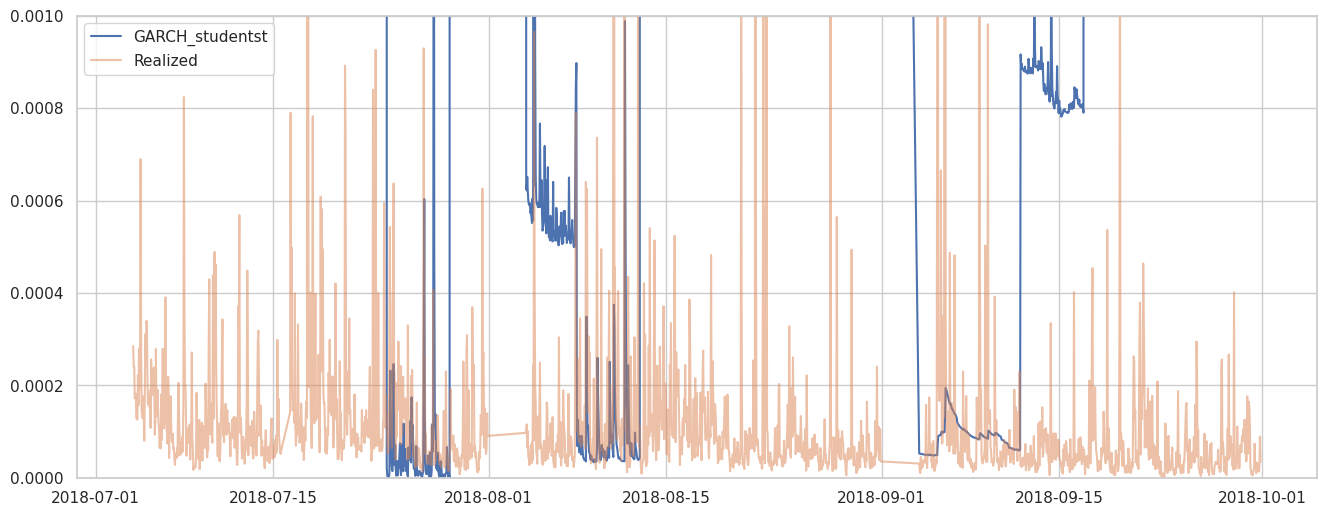

In [25]:
backtest_results_egarch = backtester.backtest(
    GARCH,
    hyperparams={"p": 1, "o": 0, "q": 1, "dist": "studentst", "type": "GARCH"},
    use_ob_feats=False,
    use_log_y=True,
)

Using t-distribution (skewed or not) leads to convergence issues, even in the expanding window. 

## HAR

100%|██████████| 1958/1958 [00:05<00:00, 341.43it/s]


Backtest finished successfully.
---------------------------------------------------
Model: HAR
RMSE: 0.0002279
MAE:  0.0000840
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


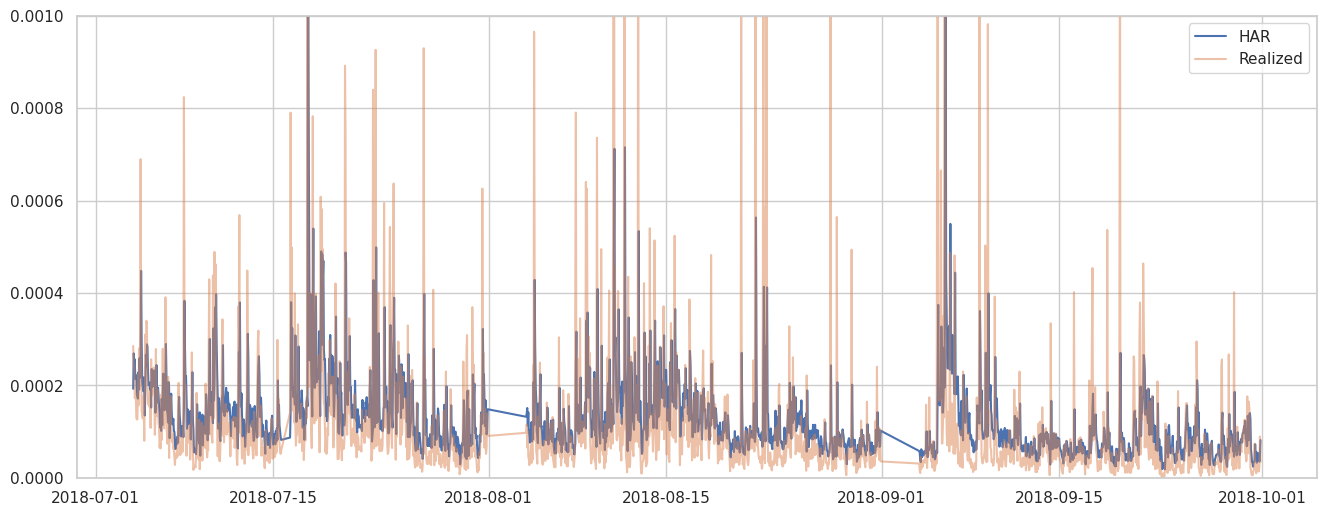

In [59]:
backtest_results_har = backtester.backtest(
    HARX,
    hyperparams={"lags": [1, 6, 24], "l2": 0.0, "is_weighted": False},
    use_ob_feats=False,
    use_log_y=True,
)

In [45]:
backtest_results_har.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"har_{suffix}.csv",
    index=True,
)

# Backtesting Multivariate models

## ARIMAX

  0%|          | 0/1958 [00:00<?, ?it/s]

/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  0%|          | 8/1958 [00:00<01:59, 16.32it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  597
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -484.588
Date:                Sun, 29 Jun 2025   AIC                            987.175
Time:                        21:34:01   BIC                           1026.702
Sample:                             0   HQIC                          1002.566
                                - 597                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.0772      0.746    -13.502      0.000     -11.540      -8.614
x1             0.3485      0.041      8.581      0.000       0.269       0.428
x2             0.1916      0.021      8.938      0.0

  6%|▌         | 111/1958 [00:02<00:21, 84.11it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  7%|▋         | 128/1958 [00:02<00:54, 33.73it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  644
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -529.639
Date:                Sun, 29 Jun 2025   AIC                           1077.279
Time:                        21:34:03   BIC                           1117.488
Sample:                             0   HQIC                          1092.881
                                - 644                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6410      0.971    -10.962      0.000     -12.544      -8.738
x1             0.3828      0.038      9.947      0.000       0.307       0.458
x2             0.1788      0.021      8.655      0.0

 12%|█▏        | 229/1958 [00:04<00:21, 79.51it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 13%|█▎        | 246/1958 [00:04<00:35, 48.10it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  643
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -529.478
Date:                Sun, 29 Jun 2025   AIC                           1076.957
Time:                        21:34:05   BIC                           1117.152
Sample:                             0   HQIC                          1092.555
                                - 643                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9370      1.227     -8.911      0.000     -13.343      -8.531
x1             0.3601      0.041      8.709      0.000       0.279       0.441
x2             0.1832      0.021      8.818      0.0

 17%|█▋        | 337/1958 [00:06<00:23, 68.90it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 18%|█▊        | 352/1958 [00:06<00:37, 42.94it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  626
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -559.757
Date:                Sun, 29 Jun 2025   AIC                           1137.514
Time:                        21:34:07   BIC                           1177.468
Sample:                             0   HQIC                          1153.037
                                - 626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -13.7121      0.792    -17.310      0.000     -15.265     -12.160
x1             0.4040      0.045      8.896      0.000       0.315       0.493
x2             0.1974      0.023      8.589      0.0

 23%|██▎       | 458/1958 [00:07<00:17, 83.79it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 24%|██▍       | 467/1958 [00:08<00:53, 27.99it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  625
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -578.157
Date:                Sun, 29 Jun 2025   AIC                           1174.314
Time:                        21:34:09   BIC                           1214.254
Sample:                             0   HQIC                          1189.833
                                - 625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.1313      0.583    -20.803      0.000     -13.274     -10.988
x1             0.4255      0.050      8.506      0.000       0.327       0.523
x2             0.1626      0.024      6.638      0.0

 29%|██▉       | 575/1958 [00:10<00:17, 80.71it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 30%|███       | 591/1958 [00:10<00:28, 47.62it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  624
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -614.572
Date:                Sun, 29 Jun 2025   AIC                           1247.143
Time:                        21:34:11   BIC                           1287.069
Sample:                             0   HQIC                          1262.658
                                - 624                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.9645      0.515    -21.289      0.000     -11.974      -9.955
x1             0.4648      0.051      9.170      0.000       0.365       0.564
x2             0.1559      0.029      5.322      0.0

 33%|███▎      | 645/1958 [00:11<00:16, 79.31it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 34%|███▍      | 662/1958 [00:11<00:27, 47.88it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  625
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -639.871
Date:                Sun, 29 Jun 2025   AIC                           1297.741
Time:                        21:34:12   BIC                           1337.681
Sample:                             0   HQIC                          1313.260
                                - 625                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8298      0.534    -20.295      0.000     -11.876      -9.784
x1             0.4480      0.054      8.344      0.000       0.343       0.553
x2             0.1337      0.033      4.064      0.0

 38%|███▊      | 739/1958 [00:12<00:14, 82.07it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 39%|███▊      | 757/1958 [00:13<00:23, 51.59it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  626
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -652.600
Date:                Sun, 29 Jun 2025   AIC                           1323.200
Time:                        21:34:13   BIC                           1363.154
Sample:                             0   HQIC                          1338.724
                                - 626                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.6371      0.484    -22.000      0.000     -11.585      -9.689
x1             0.4255      0.055      7.701      0.000       0.317       0.534
x2             0.1299      0.033      3.956      0.0

 44%|████▍     | 862/1958 [00:14<00:12, 87.68it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 45%|████▍     | 880/1958 [00:15<00:20, 53.00it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  629
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -706.152
Date:                Sun, 29 Jun 2025   AIC                           1430.304
Time:                        21:34:15   BIC                           1470.301
Sample:                             0   HQIC                          1445.841
                                - 629                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.5390      0.567    -18.585      0.000     -11.650      -9.428
x1             0.4327      0.064      6.711      0.000       0.306       0.559
x2             0.1193      0.036      3.272      0.0

 50%|████▉     | 977/1958 [00:16<00:11, 83.50it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 51%|█████     | 993/1958 [00:16<00:22, 42.32it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  645
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -719.419
Date:                Sun, 29 Jun 2025   AIC                           1456.838
Time:                        21:34:17   BIC                           1497.061
Sample:                             0   HQIC                          1472.445
                                - 645                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.4560      0.570    -18.333      0.000     -11.574      -9.338
x1             0.3952      0.066      5.963      0.000       0.265       0.525
x2             0.1213      0.037      3.320      0.0

 56%|█████▌    | 1099/1958 [00:18<00:09, 86.44it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 57%|█████▋    | 1116/1958 [00:18<00:17, 48.40it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  646
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -751.976
Date:                Sun, 29 Jun 2025   AIC                           1521.953
Time:                        21:34:19   BIC                           1562.190
Sample:                             0   HQIC                          1537.564
                                - 646                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.7025      0.541    -19.786      0.000     -11.763      -9.642
x1             0.4075      0.066      6.161      0.000       0.278       0.537
x2             0.1319      0.038      3.482      0.0

 62%|██████▏   | 1219/1958 [00:20<00:10, 72.63it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 63%|██████▎   | 1233/1958 [00:20<00:19, 37.60it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  646
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -742.304
Date:                Sun, 29 Jun 2025   AIC                           1502.608
Time:                        21:34:21   BIC                           1542.845
Sample:                             0   HQIC                          1518.220
                                - 646                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.5786      0.631    -16.775      0.000     -11.815      -9.343
x1             0.3679      0.070      5.263      0.000       0.231       0.505
x2             0.1449      0.037      3.879      0.0

 67%|██████▋   | 1318/1958 [00:22<00:08, 72.77it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 68%|██████▊   | 1326/1958 [00:22<00:19, 31.98it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  646
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -733.798
Date:                Sun, 29 Jun 2025   AIC                           1485.596
Time:                        21:34:23   BIC                           1525.834
Sample:                             0   HQIC                          1501.208
                                - 646                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -8.3391      0.843     -9.887      0.000      -9.992      -6.686
x1             0.3129      0.068      4.619      0.000       0.180       0.446
x2             0.1446      0.035      4.115      0.0

 71%|███████   | 1391/1958 [00:23<00:08, 67.32it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  646
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -767.142
Date:                Sun, 29 Jun 2025   AIC                           1552.284
Time:                        21:34:25   BIC                           1592.521
Sample:                             0   HQIC                          1567.896
                                - 646                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.5160      0.942    -11.161      0.000     -12.363      -8.669
x1             0.3679      0.070      5.283      0.000       0.231       0.504
x2             0.1719      0.036      4.801      0.0

 76%|███████▋  | 1497/1958 [00:26<00:05, 81.95it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 77%|███████▋  | 1515/1958 [00:27<00:13, 32.88it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  640
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -736.568
Date:                Sun, 29 Jun 2025   AIC                           1491.136
Time:                        21:34:27   BIC                           1531.289
Sample:                             0   HQIC                          1506.721
                                - 640                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -9.5955      1.095     -8.761      0.000     -11.742      -7.449
x1             0.3749      0.059      6.408      0.000       0.260       0.490
x2             0.1712      0.031      5.604      0.0

 83%|████████▎ | 1620/1958 [00:28<00:04, 83.64it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 84%|████████▎ | 1638/1958 [00:29<00:06, 48.11it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  640
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -727.739
Date:                Sun, 29 Jun 2025   AIC                           1473.479
Time:                        21:34:29   BIC                           1513.632
Sample:                             0   HQIC                          1489.064
                                - 640                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.1637      1.469     -6.919      0.000     -13.043      -7.285
x1             0.3399      0.053      6.402      0.000       0.236       0.444
x2             0.1665      0.031      5.440      0.0

 89%|████████▉ | 1744/1958 [00:30<00:02, 71.72it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 89%|████████▉ | 1752/1958 [00:31<00:06, 29.88it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  640
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -731.663
Date:                Sun, 29 Jun 2025   AIC                           1481.325
Time:                        21:34:31   BIC                           1521.479
Sample:                             0   HQIC                          1496.911
                                - 640                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -12.4671      1.349     -9.239      0.000     -15.112      -9.822
x1             0.3773      0.052      7.303      0.000       0.276       0.479
x2             0.1990      0.030      6.732      0.0

 95%|█████████▌| 1861/1958 [00:32<00:01, 60.44it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 95%|█████████▌| 1868/1958 [00:33<00:03, 24.91it/s]

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  641
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -779.852
Date:                Sun, 29 Jun 2025   AIC                           1577.704
Time:                        21:34:34   BIC                           1617.871
Sample:                             0   HQIC                          1593.294
                                - 641                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -14.8997      1.698     -8.777      0.000     -18.227     -11.572
x1             0.4116      0.056      7.308      0.000       0.301       0.522
x2             0.2145      0.033      6.422      0.0

100%|██████████| 1958/1958 [00:34<00:00, 56.04it/s]


Backtest finished successfully.
---------------------------------------------------
Model: ARIMAX
RMSE: 0.0002365
MAE:  0.0000921
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


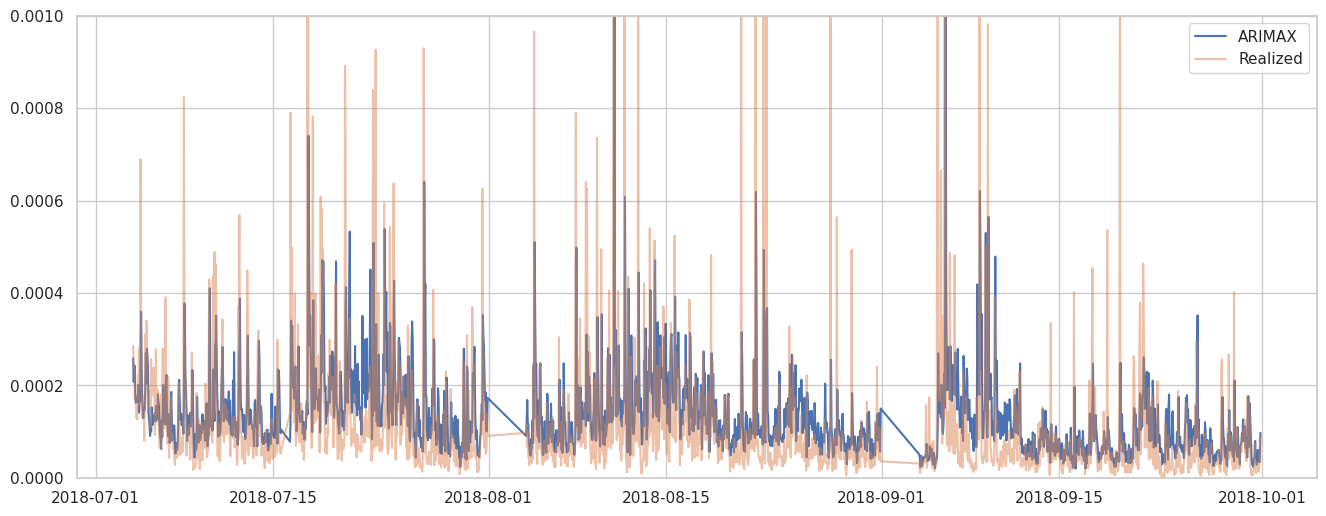

In [46]:
backtest_results_arimax = backtester.backtest(
    ARIMAX, hyperparams={"p": 1, "d": 0, "q": 2}, use_ob_feats=True, use_log_y=True
)

In [47]:
backtest_results_arimax.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"arimax_{suffix}.csv",
    index=True,
)

## HARX

100%|██████████| 1958/1958 [00:08<00:00, 231.00it/s]


Backtest finished successfully.
---------------------------------------------------
Model: HARX
RMSE: 0.0002296
MAE:  0.0000810
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


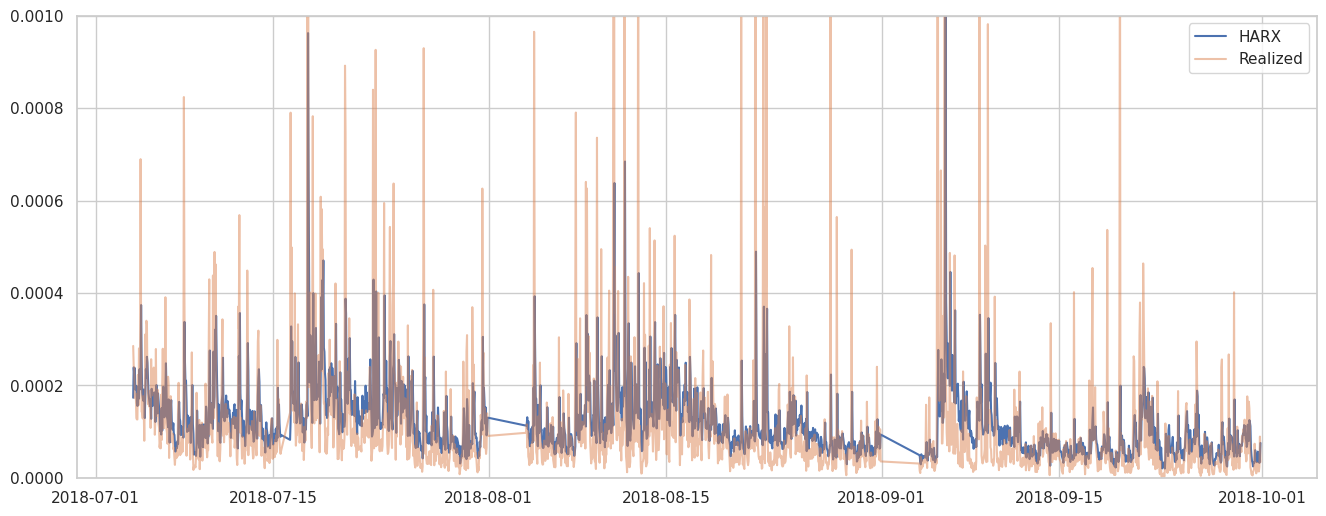

In [63]:
backtest_results_harx = backtester.backtest(
    HARX,
    hyperparams={"lags": [1, 6, 24], "l2": 100.0, "is_weighted": True},
    use_ob_feats=True,
    use_log_y=True,
)

In [64]:
backtest_results_harx.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"harx_{suffix}.csv",
    index=True,
)

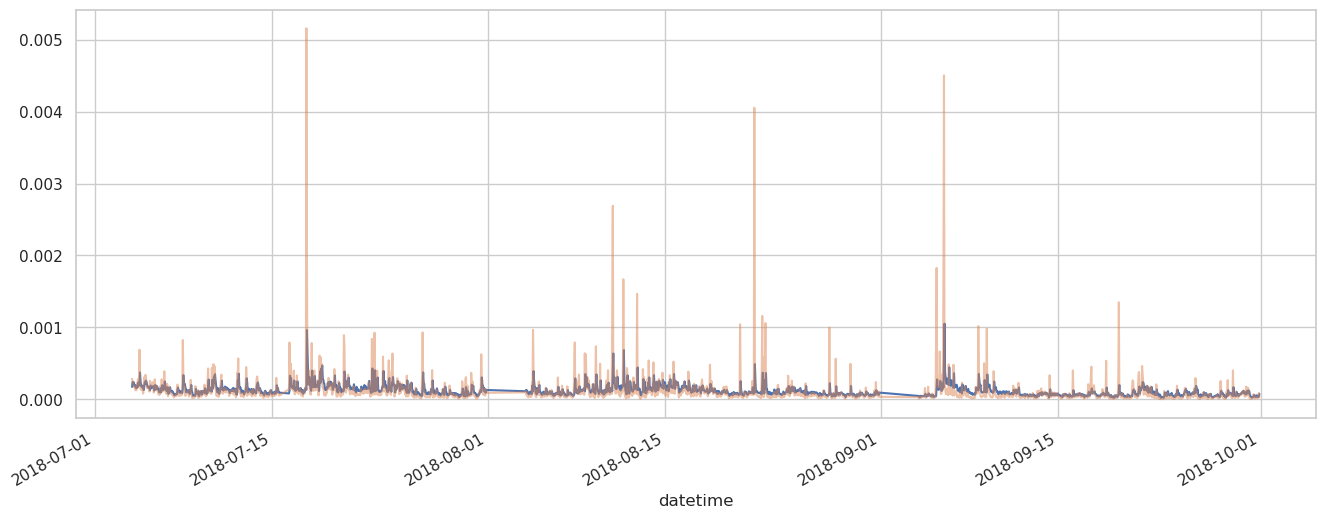

In [65]:
backtest_results_harx.forecasts.plot(label="HARX")
plt.plot(backtest_results_harx.true_vola, label="Realized", alpha=0.5)

## Elastic Net

100%|██████████| 1958/1958 [00:11<00:00, 176.76it/s]


Backtest finished successfully.
---------------------------------------------------
Model: ENET
RMSE: 0.0002307
MAE:  0.0000866
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


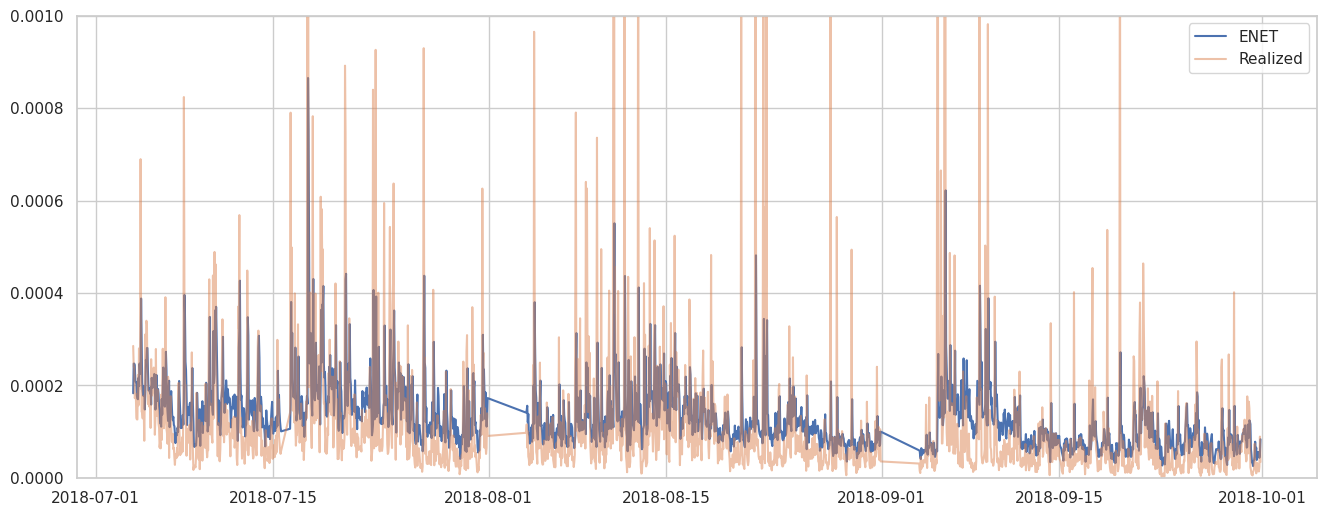

In [71]:
backtest_results_enet = backtester.backtest(
    ENET,
    hyperparams={"alpha": 0.1, "l1_ratio": 0.7, "num_vola_lags": 10},
    use_ob_feats=True,
    use_log_y=True,
)

In [73]:
backtest_results_enet.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"enet_{suffix}.csv",
    index=True,
)

## Random Forest

  0%|          | 0/1958 [00:00<?, ?it/s]

100%|██████████| 1958/1958 [00:45<00:00, 43.04it/s]


Backtest finished successfully.
---------------------------------------------------
Model: RF
RMSE: 0.0002340
MAE:  0.0000892
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


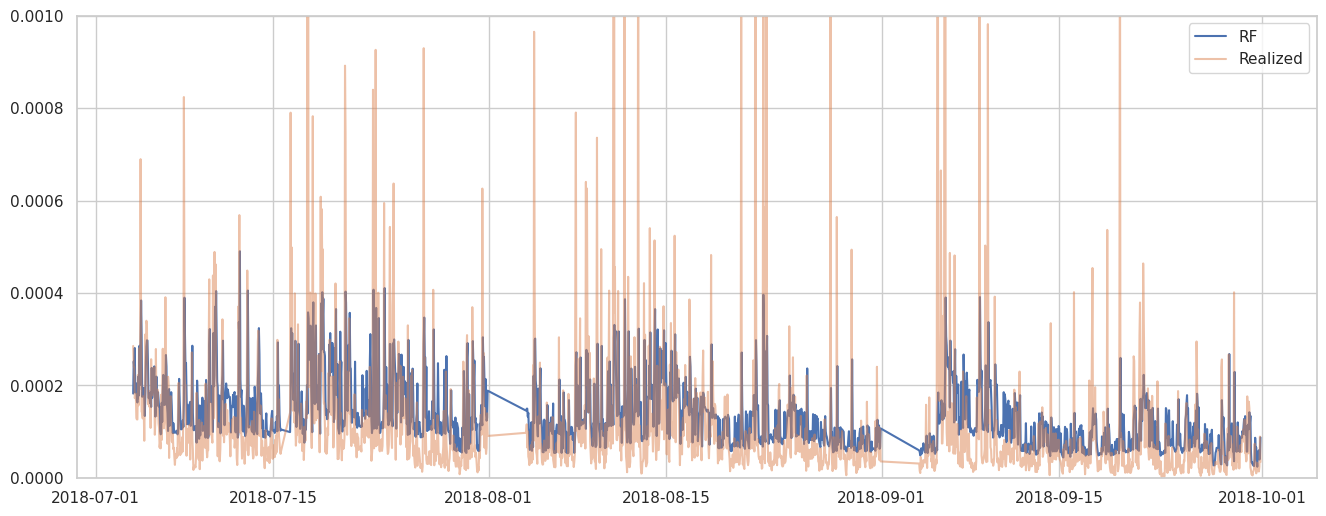

In [72]:
backtest_results_rf = backtester.backtest(
    RF,
    hyperparams={"n_estimators": 200, "max_depth": 3, "min_samples_split": 10},
    use_ob_feats=True,
    use_log_y=True,
)

In [76]:
backtest_results_rf.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"rf_{suffix}.csv",
    index=True,
)

## XGBM

  0%|          | 0/1958 [00:00<?, ?it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:46:31] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1747336936436/work/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
  6%|▌         | 119/1958 [00:01<00:27, 66.43it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:46:32] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1747336936436/work/src/learner.cc:738: 
Parameters: { "min_samples_split" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
 12%|█▏        | 230/1958 [00:02<00:16, 103.82it/s]/home/miroslav/miniforge3/envs/mlfi/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [21:46:33] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost-split_1747336936436/work/src/learner.cc:738: 
Parameter

Backtest finished successfully.
---------------------------------------------------
Model: XGBM
RMSE: 0.0002502
MAE:  0.0001116
Expanding training set: False
Test starting date: 2018-06-30 23:59:59
---------------------------------------------------


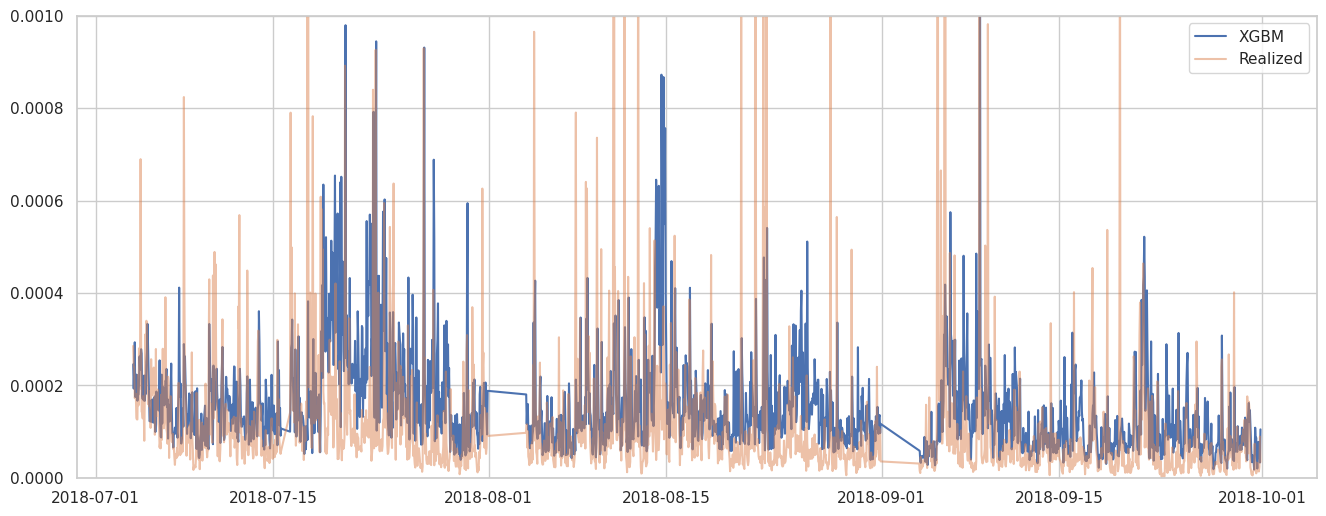

In [74]:
backtest_results_xgbm = backtester.backtest(
    XGBM,
    hyperparams={"n_estimators": 50, "max_depth": 3, "min_samples_split": 20},
    use_ob_feats=True,
)

In [75]:
backtest_results_xgbm.forecasts.to_csv(
    data_path / "output" / "benchmark_backtest" / f"xgbm_{suffix}.csv",
    index=True,
)